In [11]:
import pandas as pd
from data_pipeline.dataset import Dataset

In [12]:
df = pd.read_feather("../../data/parquet_files/train/processed_train.feather")
df.head()

,case_id,target,numberofcontrsvalue_358L_max_0,nominalrate_281L_min_0,classificationofcontr_400M_mode_0,totaldebtoverduevalue_178A_max_0,collater_valueofguarantee_876L_mean_0,pmts_overdue_1140A_max_0,credacc_cards_status_52L_mode_0,credacc_cards_status_52L_last_0
0,0,0,NaN,NaN,None,NaN,NaN,NaN,None,None
1,1,0,NaN,NaN,None,NaN,NaN,NaN,None,None
2,2,0,NaN,NaN,None,NaN,NaN,NaN,None,None
3,3,0,NaN,NaN,None,NaN,NaN,NaN,None,None
4,4,1,NaN,NaN,None,NaN,NaN,NaN,None,None


In [13]:
from hydra.utils import instantiate
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from data_pipeline.pipelinesteps import data_splitter


GlobalHydra.instance().clear()
initialize(config_path="../../", version_base=None)
cfg = compose(config_name="config")

data_pipeline = instantiate(cfg.data_pipeline)
df = pd.read_feather("../../data/parquet_files/train/processed_train.feather")
df = data_pipeline.apply(df)

dataset = Dataset(data=df, data_splitter=data_splitter, target_column='target')



In [14]:
dataset.X.head()

,case_id,numberofcontrsvalue_358L_max_0,nominalrate_281L_min_0,totaldebtoverduevalue_178A_max_0,collater_valueofguarantee_876L_mean_0,pmts_overdue_1140A_max_0,credacc_cards_status_52L_mode_0_ACTIVE,credacc_cards_status_52L_mode_0_BLOCKED,credacc_cards_status_52L_mode_0_CANCELLED,credacc_cards_status_52L_mode_0_INACTIVE,...,classificationofcontr_400M_mode_0_e5957374,classificationofcontr_400M_mode_0_e69bbbcb,classificationofcontr_400M_mode_0_e6e56e83,classificationofcontr_400M_mode_0_ea6782cc,classificationofcontr_400M_mode_0_ec922b98,classificationofcontr_400M_mode_0_edc37208,classificationofcontr_400M_mode_0_f0a30139,classificationofcontr_400M_mode_0_f920c170,classificationofcontr_400M_mode_0_fa2a66b3,classificationofcontr_400M_mode_0_fb98f5e4
0,0,NaN,NaN,NaN,NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,NaN,NaN,NaN,NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,NaN,NaN,NaN,NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,NaN,NaN,NaN,NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,NaN,NaN,NaN,NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load a binary classification dataset



# Split the data into training and test sets
X_train, X_test, y_train, y_test = dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test 

# Train a HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier()
clf.fit(X_train, y_train)

# Predict the probabilities of the positive class
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC score: {auc_score}")

AUC score: 0.5961256466128151


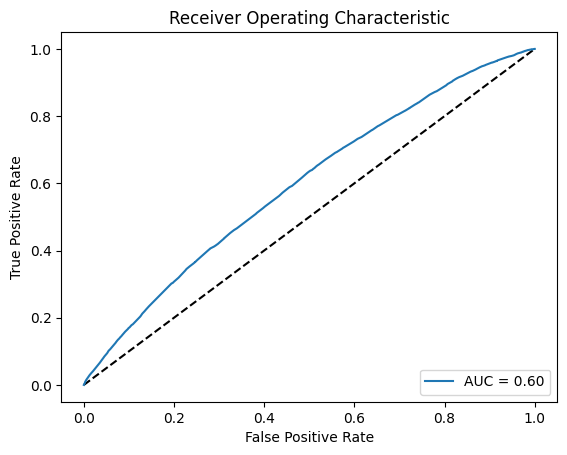

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# Plot the AUC score
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [17]:
from datetime import datetime
print(f"shap_{datetime.now()}.png")

shap_2024-02-26 09:24:03.127674.png


In [18]:
import shap
import matplotlib.pyplot as plt
from datetime import datetime
import os

def create_shap_beeswarm(model, X_data, num_of_features):

    '''Function to create a shap beeswarm plot. The input parameters are the model that is trained and from which you want to
    test the effect of the different features. X_data is a parameter that represents the training data on which the model is trained.
    At last the num_of_features parameter represents the number of features you want to show in the beeswarm plot.'''
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_data)
    fig = shap.plots.beeswarm(shap_values, max_display=num_of_features, show=False)
    path = os.path.abspath(os.path.join(os.getcwd(), '..','..','model_evaluation'))
    plt.savefig(path+f"\\beeswarm_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")
    print(path+f"\\beeswarm_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")
    return fig

In [19]:
import shap
import matplotlib.pyplot as plt
from datetime import datetime
import os

def create_heatmap(model, X_data):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_data)
    fig = shap.plots.heatmap(shap_values[:1000], show=False)
    path = os.path.abspath(os.path.join(os.getcwd(), '..','..','model_evaluation'))
    plt.savefig(path+f"\\heatmap_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")
    return fig


In [20]:
import shap
import matplotlib.pyplot as plt
from datetime import datetime
import os

def create_waterfall(model, X_data, row):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_data)
    fig = shap.plots.waterfall(shap_values[row], show=False)
    path = os.path.abspath(os.path.join(os.getcwd(), '..','..','model_evaluation'))
    plt.savefig(path+f"\\waterfall_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")
    return fig


c:\Users\junep\OneDrive\Documenten\i4talent\kaggle_challenge\home_credit\model_evaluation\beeswarm_2024-02-26_09-31-31.png


<Axes: xlabel='SHAP value (impact on model output)'>

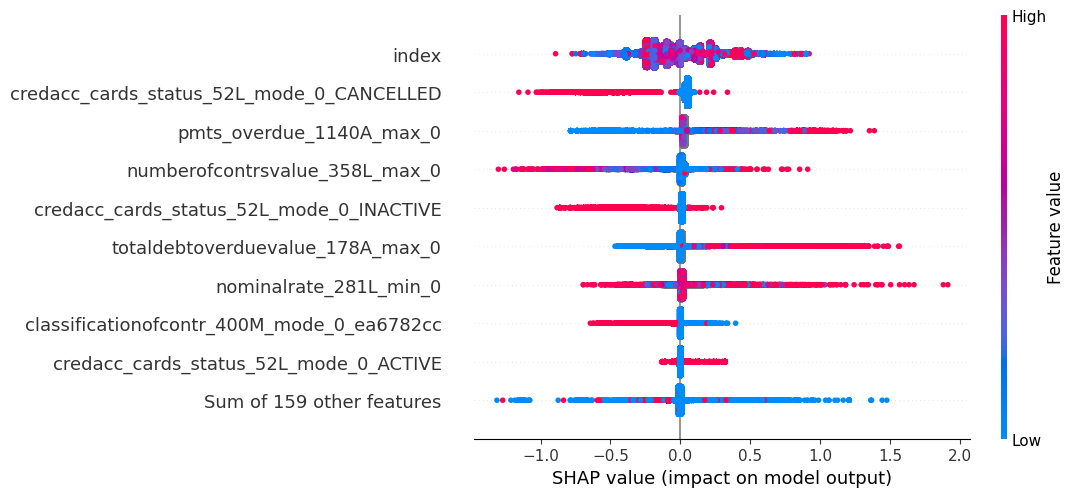

In [21]:
create_shap_beeswarm(clf, X_train, 10)

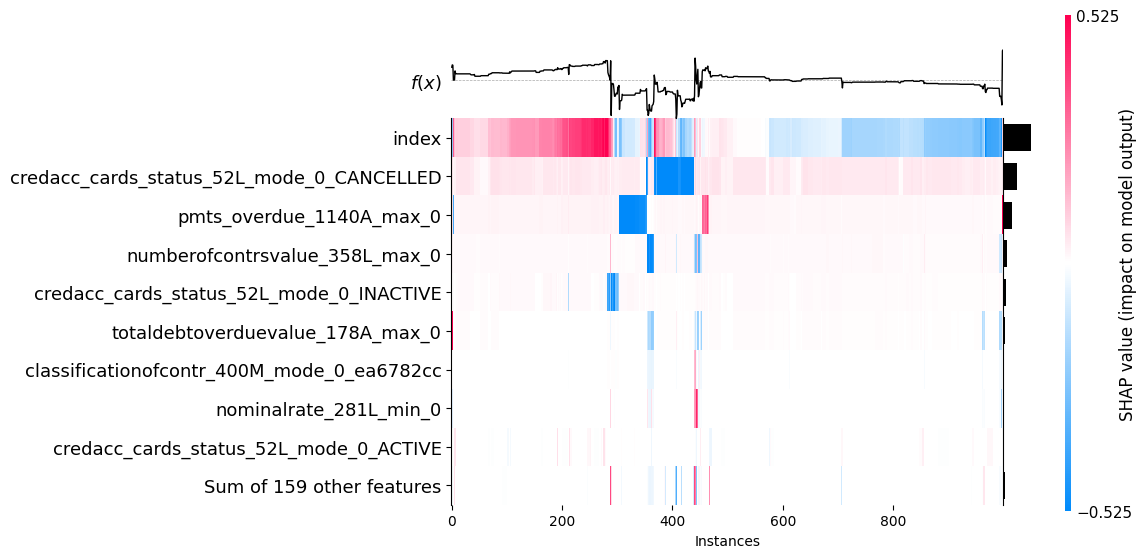

In [22]:
create_heatmap(clf, X_train)

In [23]:
create_waterfall(clf, X_train, 1)

<Axes: >

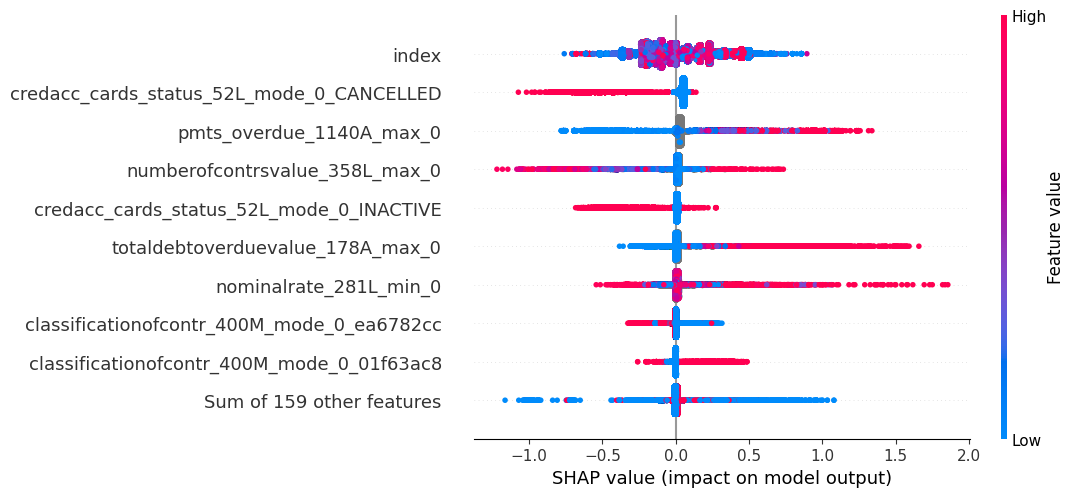

In [9]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

All-NaN slice encountered


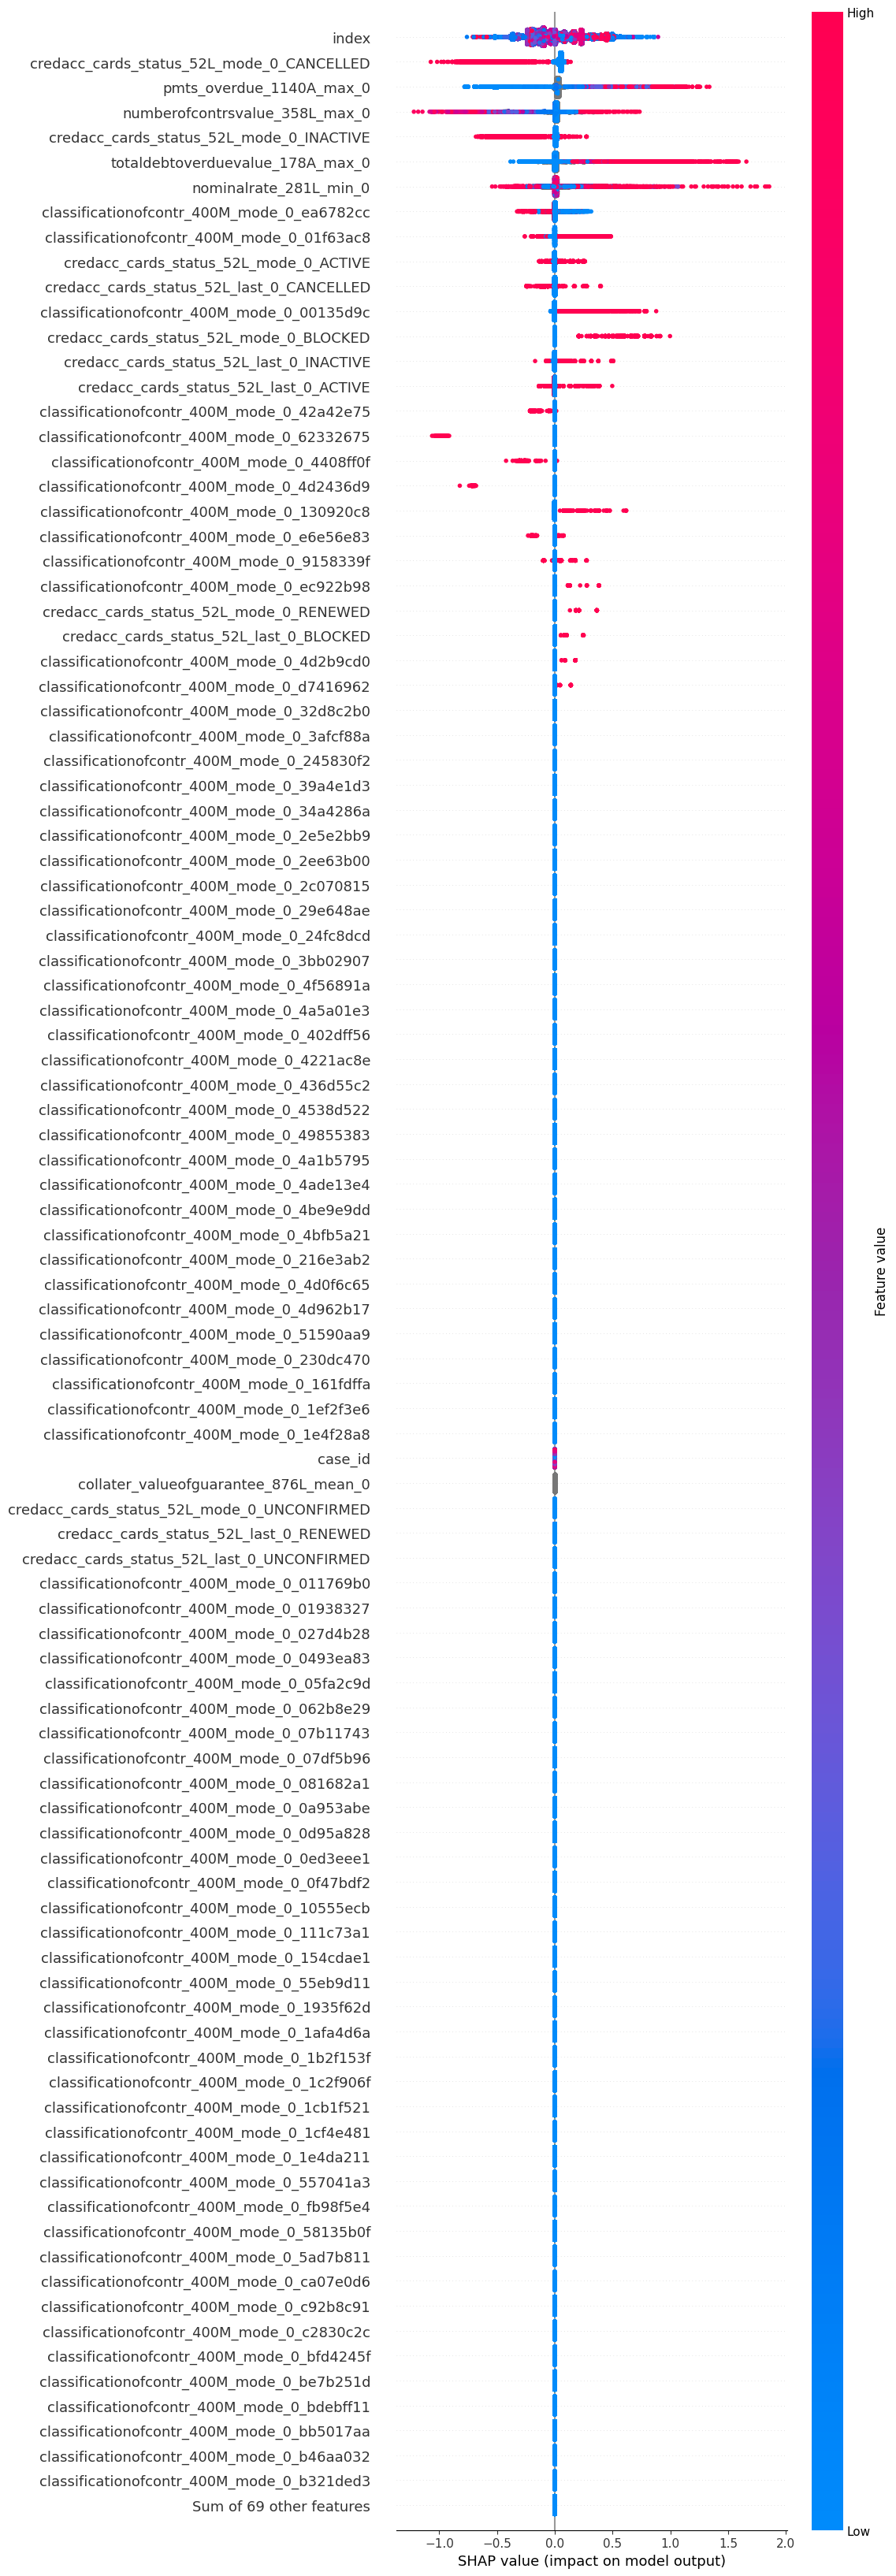

In [23]:
shap.plots.beeswarm(shap_values, max_display=100)